Importing Necessary Libraires

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import learning_curve
from collections import Counter, defaultdict
import math
from scipy.sparse import csr_matrix
from wordcloud import WordCloud

In [117]:
df = pd.read_csv("news.csv")

print(df.shape)
print(df.columns)
print(df["category"].value_counts())

(50000, 5)
Index(['category', 'headline', 'links', 'short_description', 'keywords'], dtype='object')
category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64


Filtering out Sports and Politics for our new df

In [118]:
df["category"] = df["category"].astype(str).str.upper() #converting to uppercase for our search
target_data = df[df["category"].isin(["POLITICS", "SPORTS"])] #taking out only politics and sports for our df

print(target_data.shape)
print(target_data["category"].value_counts())

(10000, 5)
category
POLITICS    5000
SPORTS      5000
Name: count, dtype: int64


Resetting the Indices and saving this new dataframe as a CSV

In [119]:
target_data= target_data.reset_index(drop=True)
target_data.to_csv("B23CS1059_prob4_dataset.csv", index=False)

Setting 0 - POLITICS  &&  1 - SPORTS

In [120]:
label_map = {"SPORTS":1,"POLITICS":0}
target_data["label"] = target_data["category"].map(label_map)

Visualizing the Class Distribution

In [121]:
target_data["text"] = (
    target_data["headline"].fillna("") + " " +
    target_data["short_description"].fillna("")
)


In [122]:
target_data[["headline", "short_description", "text"]].head()

,headline,short_description,text
0,GOP Congressman Suggests Looser Standard Of Pr...,"Rep. Lee Zeldin says there needs to be ""some t...",GOP Congressman Suggests Looser Standard Of Pr...
1,The ACLU Is Suing To Strike Down Ohio's Congre...,The civil liberties group says Ohio's map is s...,The ACLU Is Suing To Strike Down Ohio's Congre...
2,Don't Like The New Climate Rules? Thank Congress.,Legislators could have passed a climate change...,Don't Like The New Climate Rules? Thank Congre...
3,The Story Behind An Iconic Picture Of Civil Ri...,An often-forgotten battle for free speech righ...,The Story Behind An Iconic Picture Of Civil Ri...
4,Pro-Abortion Rights Progressive Wins Nebraska ...,Kara Eastman prevailed against an establishmen...,Pro-Abortion Rights Progressive Wins Nebraska ...


Cleaning by Lowercasing & Removal of Punctuation Marks, Numbers, Extra Spaces

In [124]:
def preprocess_string(text):
    text=text.lower()
    text= re.sub(r"http\S+|www\S+", "",text)   #removing URLs
    text= re.sub(r"[^a-z\s]"," ",text)        #keeping only letters
    text= re.sub(r"\s+"," ",text).strip()     #stripping extra spaces
    return text

In [125]:
target_data["clean_text"]= target_data["text"].apply(preprocess_string)

Train-Test-Split

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [127]:
X= target_data["clean_text"].values
y= target_data["label"].values

X_train, X_test, y_train, y_test= train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

print("Train size:",len(X_train))
print("Test size:",len(X_test))

Train size: 8000
Test size: 2000


#Feature Representation

In [128]:
IGNORE_WORDS = set(["i","me","my","myself","we","our","ours","ourselves","you","your","yours","he","him","his","she","her","hers","it","its","they","them","their","theirs","what","which","who","whom","this","that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did","doing","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against","between","into","through","during","before","after","above","below","to","from","up","down","in","out","on","off","over","under","again","further","then","once","here","there","when","where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"])

Tokenisation removes stop words & single char to create single words

In [129]:
def tokenize(text, use_bigrams=False):
    words= [w for w in text.split() if w not in STOP_WORDS and len(w) > 1]
    tokens= list(words)
    if use_bigrams:
        tokens.extend([f"{words[i]}_{words[i+1]}" for i in range(len(words)-1)])
    return tokens

Dictionary creater

In [131]:
def generate_vocab(texts, max_features, use_bigrams=False):
    doc_freq= defaultdict(int)
    for t in texts: #counts how many docs contain each word
        tokens = set(tokenize(t, use_bigrams))
        for te in tokens:
            doc_freq[te] += 1

    #keeps only the most freq words up to 'max_features'
    sorted_vocab= sorted(doc_freq.items(), key=lambda x: x[1], reverse=True)[:max_features]
    vocab= {word: i for i, (word, count) in enumerate(sorted_vocab)} #unique id to each word
    feature_names= [word for word, count in sorted_vocab]
    return vocab,doc_freq,feature_names

In [132]:
def extract_features(texts,vocab,doc_freq,mode='bow',use_bigrams=False):
    rows,cols,data = [], [], []
    total_docs= len(texts)
    #converts raw text into math matrix
    for row_idx,text in enumerate(texts):
        tokens= tokenize(text,use_bigrams)
        if not tokens: continue

        counts= Counter(tokens)
        total_tokens= len(tokens)

        row_cols,row_vals = [], []

        for token,cnt in counts.items():
            if token in vocab:
                col_idx=vocab[token]
                if mode=='bow': # bow is raw frequency
                    val=cnt
                elif mode=='tfidf': # Term Freq Inverse Doc Freq represents weighted importance
                    tf= cnt/total_tokens
                    idf= math.log(total_docs/(1 + doc_freq[token]))
                    val= tf*idf

                row_cols.append(col_idx)
                row_vals.append(val)

        # L2 Normalization for TF-IDF
        if mode == 'tfidf' and row_vals: #makes sure every article has same amt of weight
            norm= math.sqrt(sum(v**2 for v in row_vals))
            if norm > 0:
                row_vals = [v/norm for v in row_vals]

        rows.extend([row_idx]*len(row_cols))
        cols.extend(row_cols)
        data.extend(row_vals)

    # scipy matrix only points out words used
    return csr_matrix((data, (rows, cols)), shape=(len(texts), len(vocab)))

1. Bag of Words (Max 10,000 features)

In [135]:
print("Building Bag of Word Features:\n")
vocab_bow,df_bow,bow_names = generate_vocab(X_train, max_features=10000, use_bigrams=False)
X_train_bow= extract_features(X_train,vocab_bow, df_bow, mode='bow',use_bigrams=False)
X_test_bow= extract_features(X_test,vocab_bow, df_bow, mode='bow',use_bigrams=False)
print("BoW shape:", X_train_bow.shape)


Building Bag of Word Features:

BoW shape: (8000, 10000)



 2. TF-IDF (Max 10,000 features)

In [136]:
print("\nBuilding TF-IDF Features:\n")
vocab_tfidf, df_tfidf, tfidf_names = generate_vocab(X_train, max_features=10000, use_bigrams=False)
X_train_tfidf = extract_features(X_train, vocab_tfidf, df_tfidf, mode='tfidf', use_bigrams=False)
X_test_tfidf = extract_features(X_test, vocab_tfidf, df_tfidf, mode='tfidf', use_bigrams=False)
print("TF-IDF shape:", X_train_tfidf.shape)


Building TF-IDF Features:

TF-IDF shape: (8000, 10000)


3. TF-IDF with N-Grams (Max 15,000 features)

In [137]:
print("\nBuilding TF-IDF N-Gram Features...")
vocab_ng, df_ng, ng_names = generate_vocab(X_train, max_features=15000, use_bigrams=True)
X_train_tfidf_ng = extract_features(X_train, vocab_ng, df_ng, mode='tfidf', use_bigrams=True)
X_test_tfidf_ng = extract_features(X_test, vocab_ng, df_ng, mode='tfidf', use_bigrams=True)
print("TF-IDF ngram shape:", X_train_tfidf_ng.shape)


Building TF-IDF N-Gram Features...
TF-IDF ngram shape: (8000, 15000)


In [146]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n\n{name}'s Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [147]:
nb= MultinomialNB()
lr= LogisticRegression(max_iter=1000)
svm= LinearSVC()

In [149]:
train_and_evaluate(nb, X_train_bow, X_test_bow, y_train, y_test, "NB + BoW")
train_and_evaluate(lr, X_train_bow, X_test_bow, y_train, y_test, "LR + BoW")
train_and_evaluate(svm, X_train_bow, X_test_bow, y_train, y_test, "SVM + BoW")



NB + BoW's Accuracy: 0.9785
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



LR + BoW's Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



SVM + BoW's Accuracy: 0.9745
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1000
           1       0.97      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      

In [150]:
train_and_evaluate(nb, X_train_tfidf, X_test_tfidf, y_train, y_test, "NB + TF-IDF")
train_and_evaluate(lr, X_train_tfidf, X_test_tfidf, y_train, y_test, "LR + TF-IDF")
train_and_evaluate(svm, X_train_tfidf, X_test_tfidf, y_train, y_test, "SVM + TF-IDF")



NB + TF-IDF's Accuracy: 0.9685
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1000
           1       0.97      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



LR + TF-IDF's Accuracy: 0.9815
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



SVM + TF-IDF's Accuracy: 0.9795
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98     

In [151]:
train_and_evaluate(nb, X_train_tfidf_ng, X_test_tfidf_ng, y_train, y_test, "NB + TF-IDF ngram")
train_and_evaluate(lr, X_train_tfidf_ng, X_test_tfidf_ng, y_train, y_test, "LR + TF-IDF ngram")
train_and_evaluate(svm, X_train_tfidf_ng, X_test_tfidf_ng, y_train, y_test, "SVM + TF-IDF ngram")



NB + TF-IDF ngram's Accuracy: 0.967
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1000
           1       0.99      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



LR + TF-IDF ngram's Accuracy: 0.981
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1000
           1       0.98      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



SVM + TF-IDF ngram's Accuracy: 0.9805
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg

Feature Representation vs. ML Algorithm

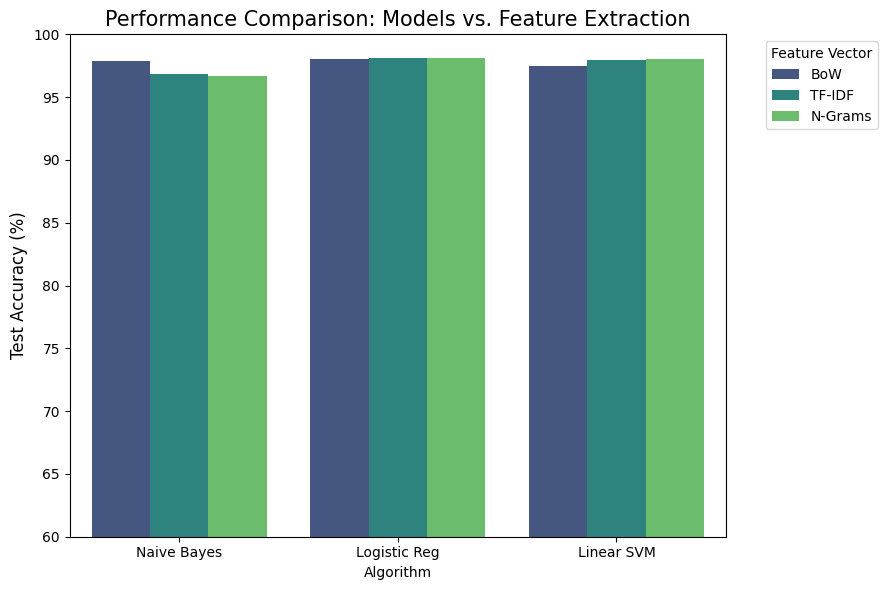

In [154]:
results = {
    'Algorithm': ['Naive Bayes', 'Naive Bayes', 'Naive Bayes',
                  'Logistic Reg', 'Logistic Reg', 'Logistic Reg',
                  'Linear SVM', 'Linear SVM', 'Linear SVM'],
    'Feature': ['BoW', 'TF-IDF', 'N-Grams', 'BoW', 'TF-IDF', 'N-Grams', 'BoW', 'TF-IDF', 'N-Grams'],
    'Accuracy': [
        accuracy_score(y_test, nb.fit(X_train_bow, y_train).predict(X_test_bow)),
        accuracy_score(y_test, nb.fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
        accuracy_score(y_test, nb.fit(X_train_tfidf_ng, y_train).predict(X_test_tfidf_ng)),

        accuracy_score(y_test, lr.fit(X_train_bow, y_train).predict(X_test_bow)),
        accuracy_score(y_test, lr.fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
        accuracy_score(y_test, lr.fit(X_train_tfidf_ng, y_train).predict(X_test_tfidf_ng)),

        accuracy_score(y_test, svm.fit(X_train_bow, y_train).predict(X_test_bow)),
        accuracy_score(y_test, svm.fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
        accuracy_score(y_test, svm.fit(X_train_tfidf_ng, y_train).predict(X_test_tfidf_ng))
    ]
}

comp_df= pd.DataFrame(results)
comp_df['Accuracy']= comp_df['Accuracy']*100 # Convert to percentage

plt.figure(figsize=(9,6))
sns.barplot(data=comp_df, x='Algorithm', y='Accuracy', hue='Feature', palette='viridis')
plt.title('Performance Comparison: Models vs. Feature Extraction', fontsize=15)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.ylim(60, 100)
plt.legend(title='Feature Vector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

VISUALISATION

In [155]:
target_data["doc_length"] = target_data["clean_text"].apply(lambda x: len(x.split()))

/tmp/ipython-input-706879453.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(s_counts), y=list(s_words), ax=axes[0], palette="Blues_r")
/tmp/ipython-input-706879453.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(p_counts), y=list(p_words), ax=axes[1], palette="Reds_r")


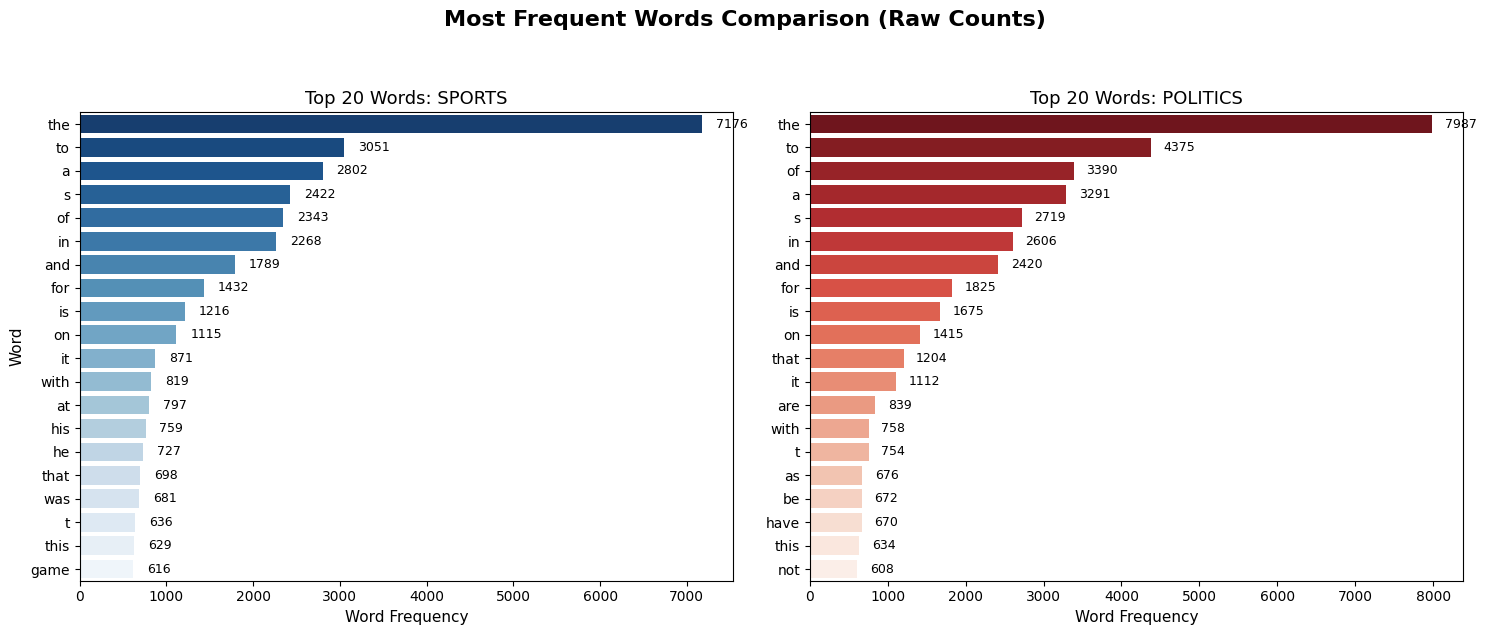

In [157]:
def top_words_by_class(df, category, n=20):
    text = " ".join(df[df["category"] == category]["clean_text"])
    words = text.split()
    counter = Counter(words)
    return counter.most_common(n)

sports_words = top_words_by_class(target_data,"SPORTS",20)
politics_words = top_words_by_class(target_data,"POLITICS",20)

s_words, s_counts = zip(*sports_words)
p_words, p_counts = zip(*politics_words)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Most Frequent Words Comparison (Raw Counts)', fontsize=16, fontweight='bold', y=1.05)

sns.barplot(x=list(s_counts), y=list(s_words), ax=axes[0], palette="Blues_r")
axes[0].set_title("Top 20 Words: SPORTS", fontsize=13)
axes[0].set_xlabel("Word Frequency", fontsize=11)
axes[0].set_ylabel("Word", fontsize=11)

sns.barplot(x=list(p_counts), y=list(p_words), ax=axes[1], palette="Reds_r")
axes[1].set_title("Top 20 Words: POLITICS", fontsize=13)
axes[1].set_xlabel("Word Frequency", fontsize=11)
axes[1].set_ylabel("") # Keep it clean by hiding the y-label on the right


for ax in axes:
    for p in ax.patches:
        width = p.get_width()
        # Add the exact count slightly to the right of the bar
        ax.text(width + (max(s_counts + p_counts) * 0.02),
                p.get_y() + p.get_height() / 2,
                f'{int(width)}',
                ha='left', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

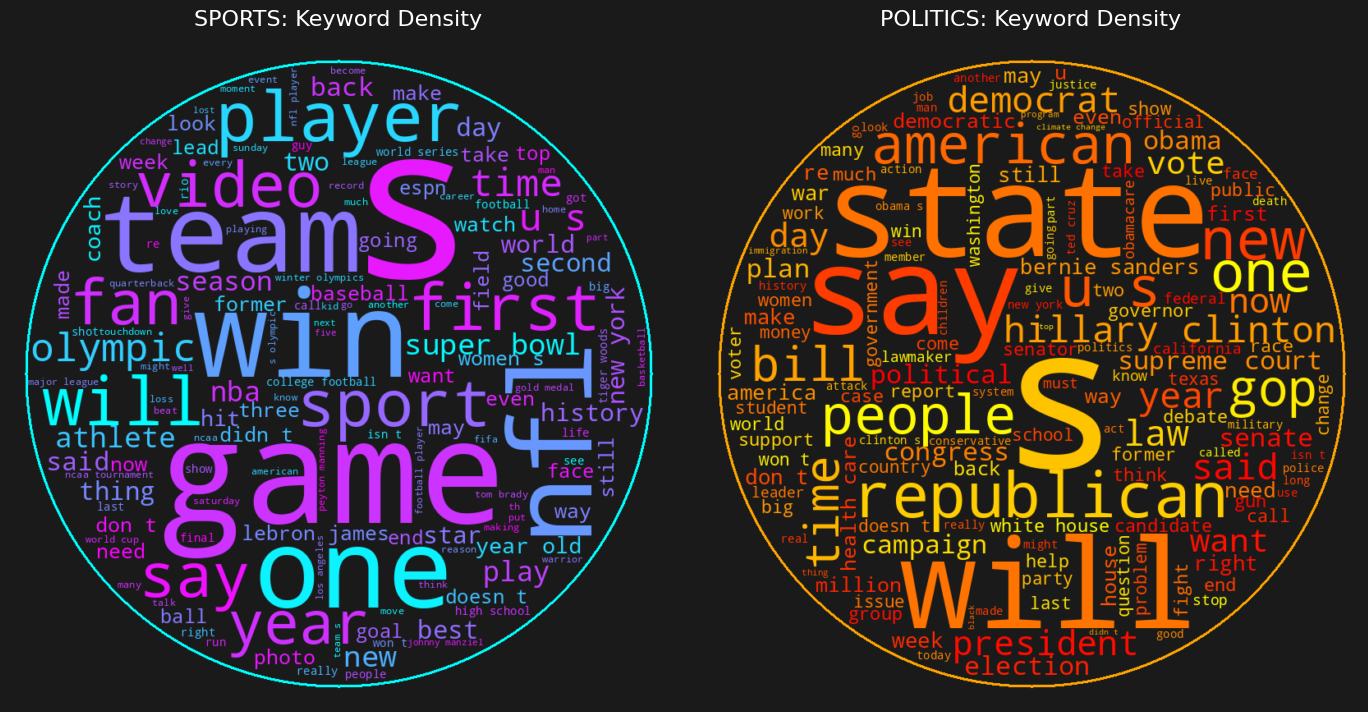

In [160]:

sports_text = " ".join(target_data[target_data["category"] == "SPORTS"]["clean_text"])
politics_text = " ".join(target_data[target_data["category"] == "POLITICS"]["clean_text"])

# circular mask using numpy
x,y = np.ogrid[:800, :800]
circle_mask = ((x - 400)** 2 + (y - 400)** 2 > 380 ** 2).astype(int)*255

# Sports Word Cloud (dark+cool)
wc_sports = WordCloud(width=800, height=800,
                      background_color="#1a1a1a", # Dark charcoal background
                      colormap="cool",            # Blue/Cyan/Magenta tones
                      mask=circle_mask,
                      contour_width=2,
                      contour_color="cyan",
                      max_words=150).generate(sports_text)

# Politics Word Cloud dark+autumn
wc_politics = WordCloud(width=800, height=800,
                        background_color="#1a1a1a",
                        colormap="autumn",          # Red/Orange/Yellow tones
                        mask=circle_mask,
                        contour_width=2,
                        contour_color="orange",
                        max_words=150).generate(politics_text)


plt.figure(figsize=(14, 7), facecolor='#1a1a1a') #dark bg
#Sportsplot
plt.subplot(1, 2, 1)
plt.imshow(wc_sports, interpolation="bilinear")
plt.axis("off")
plt.title("SPORTS: Keyword Density", color="white", fontsize=16, pad=15)
#Politics plot
plt.subplot(1, 2, 2)
plt.imshow(wc_politics, interpolation="bilinear")
plt.axis("off")
plt.title("POLITICS: Keyword Density", color="white", fontsize=16, pad=15)

plt.tight_layout()
plt.show()

visual feature engineering using tfidf

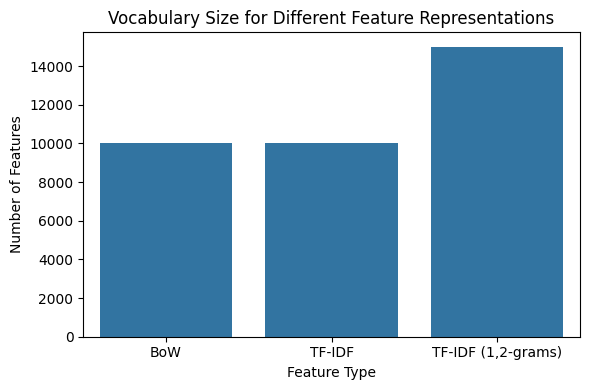

In [161]:
features = ["BoW", "TF-IDF", "TF-IDF (1,2-grams)"]
sizes = [len(bow_names), len(tfidf_names), len(ng_names)]

plt.figure(figsize=(6,4))
sns.barplot(x=features, y=sizes)
plt.title("Vocabulary Size for Different Feature Representations")
plt.ylabel("Number of Features")
plt.xlabel("Feature Type")
plt.tight_layout()
plt.show()


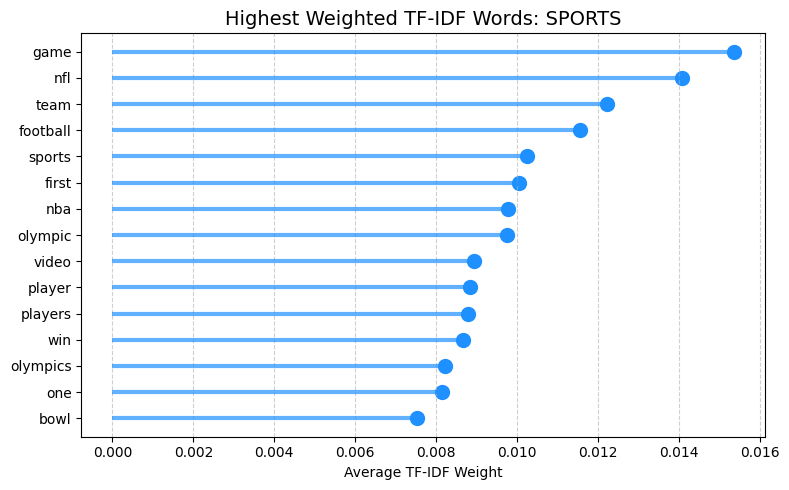

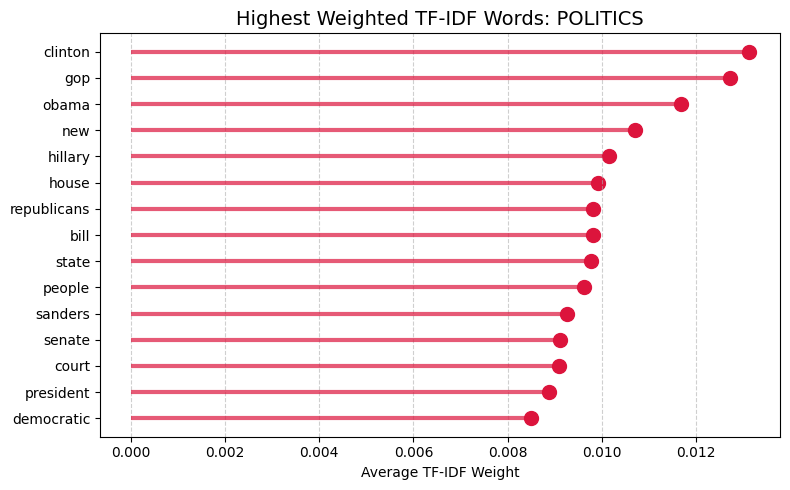

In [162]:
def plot_lollipop(values, labels, title, color): #top tfidf features
    plt.figure(figsize=(8, 5))
    plt.hlines(y=range(len(labels)), xmin=0, xmax=values, color=color, alpha=0.7, linewidth=3) #stems
    plt.scatter(values, range(len(labels)), color=color, s=100, alpha=1) #dots
    plt.yticks(range(len(labels)), labels)
    plt.title(title, fontsize=14)
    plt.xlabel("Average TF-IDF Weight")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# sports
plot_lollipop(mean_tfidf_sports[top_sports_idx], feature_names_arr[top_sports_idx],
              "Highest Weighted TF-IDF Words: SPORTS", "dodgerblue")
# politics
plot_lollipop(mean_tfidf_politics[top_politics_idx], feature_names_arr[top_politics_idx],
              "Highest Weighted TF-IDF Words: POLITICS", "crimson")

Confusion Matrix

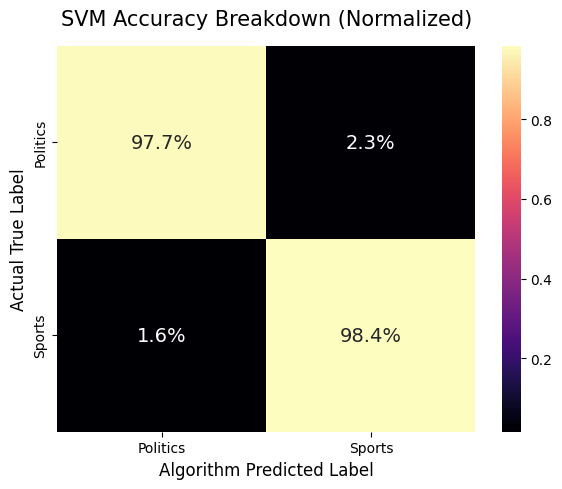

In [163]:
# Normalized Confusion Matrix for (SVM)
best_model = svm
best_model.fit(X_train_tfidf_ng, y_train)
y_pred = best_model.predict(X_test_tfidf_ng)

# Normalize by the 'true' label rows to get percentages
cm_percent = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1%", cmap="magma",
            xticklabels=["Politics", "Sports"],
            yticklabels=["Politics", "Sports"],
            annot_kws={"size": 14})
plt.xlabel("Algorithm Predicted Label", fontsize=12)
plt.ylabel("Actual True Label", fontsize=12)
plt.title("SVM Accuracy Breakdown (Normalized)", fontsize=15, pad=15)
plt.tight_layout()
plt.show()

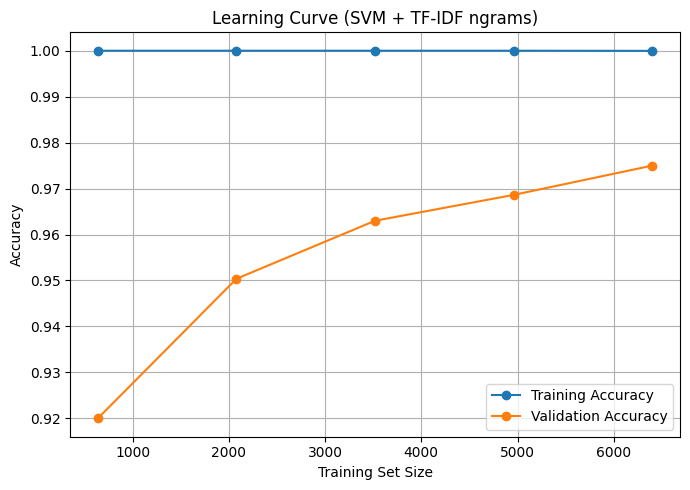

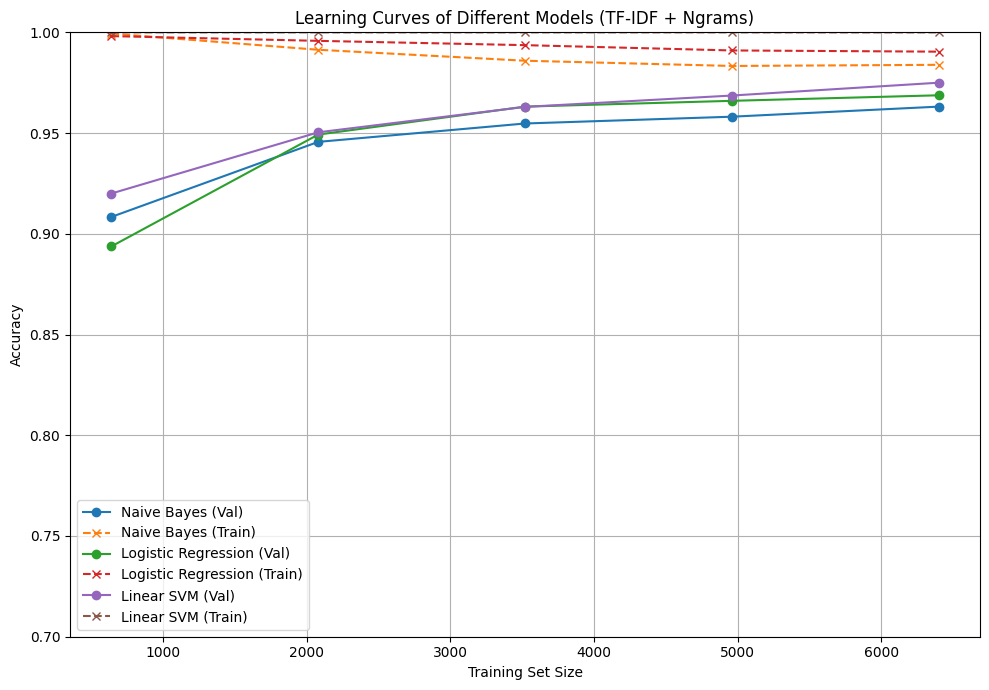

In [113]:
best_model = svm
best_model.fit(X_train_tfidf_ng, y_train)
y_pred = best_model.predict(X_test_tfidf_ng)



train_sizes, train_scores, val_scores = learning_curve(
    svm, X_train_tfidf_ng, y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5, scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Training Accuracy")
plt.plot(train_sizes, val_mean, marker="o", label="Validation Accuracy")
plt.title("Learning Curve (SVM + TF-IDF ngrams)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC()
}


plt.figure(figsize=(10, 7))

train_sizes = np.linspace(0.1, 1.0, 5)

for name, model in models.items():
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model,
        X_train_tfidf_ng,
        y_train,
        train_sizes=train_sizes,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    # Plot only validation curves (cleaner), or both if you want
    plt.plot(train_sizes_abs, val_mean, marker="o", label=f"{name} (Val)")
    # Optional: also plot training
    plt.plot(train_sizes_abs, train_mean, marker="x", linestyle="--", label=f"{name} (Train)")

plt.title("Learning Curves of Different Models (TF-IDF + Ngrams)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)   # adjust if needed
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()